# environment

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)
%cd /content/gdrive/My\ Drive/
!pip install -r colab_requirements.txt
!pip install torch==1.5.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install transformers
# It may be required to restart the runtime after executing this cell
import os
import re
import csv
import math
import time
import random
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import AutoModel, AutoTokenizer
from transformers.models.bert.modeling_bert import SequenceClassifierOutput

%matplotlib inline
if torch.cuda.is_available():
  print(torch.cuda.get_device_name())
else:
  print("Using CPU, change runtime type to speed up fine-tuning")


Mounted at /content/gdrive/
/content/gdrive/My Drive
  Using cached absl-py-0.9.0.tar.gz (104 kB)
  Using cached altair-4.1.0-py3-none-any.whl (727 kB)
  Using cached asgiref-3.2.10-py3-none-any.whl (19 kB)
  Using cached astropy-4.0.1.post1-cp37-cp37m-manylinux1_x86_64.whl (6.5 MB)
  Using cached atari_py-0.2.6-cp37-cp37m-manylinux1_x86_64.whl (2.8 MB)
  Using cached attrs-19.3.0-py2.py3-none-any.whl (39 kB)
  Using cached audioread-2.1.8.tar.gz (21 kB)
  Using cached Babel-2.8.0-py2.py3-none-any.whl (8.6 MB)
  Using cached bleach-3.1.5-py2.py3-none-any.whl (151 kB)
  Using cached bokeh-2.1.1.tar.gz (19.3 MB)
  Using cached boto-2.49.0-py2.py3-none-any.whl (1.4 MB)
  Using cached boto3-1.14.24-py2.py3-none-any.whl (128 kB)
  Using cached botocore-1.17.24-py2.py3-none-any.whl (6.4 MB)
  Using cached branca-0.4.1-py3-none-any.whl (24 kB)
  Using cached CacheControl-0.12.6-py2.py3-none-any.whl (19 kB)
  Using cached cachetools-4.1.1-py3-none-any.whl (10 kB)
  Using cached certifi-2020.6.

In [2]:
def standardize_text(string):
  """
  Removes non-alphanumeric characters except hyphens
  Removes extra whitespaces
  """
  pattern = re.compile('[\W_]+')
  temp = pattern.sub(' ', string)
  temp = ' '.join(temp.split())
  temp = temp.lower()

  return temp


def make_tuple(string):
  toks = string.split('&')
  for i, tok in enumerate(toks):
    t = tok.split()
    t = ' '.join(t)
    toks[i] = t
  return tuple(toks)

def joining(text, triple):
  if len(triple) != 3:
    print(triple)
  sub, pred, obj = triple
  text = ' '.join(text.split()) # Clears extra spaces
  
  text += f" [SEP] {sub} {pred} {obj}"
  return text

def triple_joining(triple):
  sub, pred, obj = triple
  return ' '.join([sub, pred, obj])


class PubMedBERT(nn.Module):
  """
  The PubMed implementation does not include a classification head
  so one must be added. The classification head is added in the same manner
  as the other HuggingFace BERT models for consistency.
  """
  def __init__(self):
    super().__init__()
    self.weight_path = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
    self.bert = AutoModel.from_pretrained(self.weight_path)
    self.drop = nn.Dropout(0.1, False)
    self.fc_out = nn.Linear(768, 2, True)

  def forward(self, input_ids, token_type_ids, attention_masks,
              return_dict=None):
    outputs = self.bert(input_ids, 
                             attention_mask=attention_masks,
                             token_type_ids=token_type_ids
                             )
    pooled_output = outputs[1]
    pooled_output = self.drop(pooled_output)
    logits = self.fc_out(pooled_output)

    loss = None
    if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

    return SequenceClassifierOutput(loss=loss, logits=logits,
                                    hidden_states=outputs.hidden_states, 
                                    attentions=outputs.attentions)


class BioClinicalBERT(nn.Module):
  """
  The Bio Clinical BERT implementation does not include a classification head
  so one must be added. The classification head is added in the same manner
  as the other HuggingFace BERT models for consistency.
  """
  def __init__(self):
    super().__init__()
    self.weight_path = "emilyalsentzer/Bio_ClinicalBERT"
    self.bert = AutoModel.from_pretrained(self.weight_path)
    self.drop = nn.Dropout(0.1, False)
    self.fc_out = nn.Linear(768, 2, True)

  def forward(self, input_ids, token_type_ids, attention_masks,
              return_dict=None):
    outputs = self.bert(input_ids, 
                             attention_mask=attention_masks,
                             token_type_ids=token_type_ids
                             )
    pooled_output = outputs[1]
    pooled_output = self.drop(pooled_output)
    logits = self.fc_out(pooled_output)

    loss = None
    if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

    return SequenceClassifierOutput(loss=loss, logits=logits,
                                    hidden_states=outputs.hidden_states, 
                                    attentions=outputs.attentions)


class BioBERT(nn.Module):
  """
  The Bio BERT implementation does not include a classification head
  so one must be added. The classification head is added in the same manner
  as the other HuggingFace BERT models for consistency.
  """
  def __init__(self):
    super().__init__()
    self.weight_path = "./biobert_v1.1_pubmed/"
    self.bert = AutoModel.from_pretrained(self.weight_path, force_download=True)
    self.drop = nn.Dropout(0.1, False)
    self.fc_out = nn.Linear(768, 2, True)
    
  def forward(self, input_ids, token_type_ids, attention_masks,
              return_dict=None):
    outputs = self.bert(input_ids, 
                             attention_mask=attention_masks,
                             token_type_ids=token_type_ids
                             )
    pooled_output = outputs[1]
    pooled_output = self.drop(pooled_output)
    logits = self.fc_out(pooled_output)

    loss = None
    if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

    return SequenceClassifierOutput(loss=loss, logits=logits,
                                    hidden_states=outputs.hidden_states, 
                                    attentions=outputs.attentions)


class BlueBERT(nn.Module):
  """
  The BlueBERT implementation does not include a classification head
  so one must be added. The classification head is added in the same manner
  as the other HuggingFace BERT models for consistency.
  """
  def __init__(self):
    super().__init__()
    self.weight_path = "./ncbi_bert_pubmed_mimic_uncased/"
    self.bert = AutoModel.from_pretrained(self.weight_path, force_download=True)
    self.drop = nn.Dropout(0.1, False)
    self.fc_out = nn.Linear(768, 2, True)

  def forward(self, input_ids, token_type_ids, attention_masks,
              return_dict=None):
    outputs = self.bert(input_ids, 
                             attention_mask=attention_masks,
                             token_type_ids=token_type_ids
                             )
    pooled_output = outputs[1]
    pooled_output = self.drop(pooled_output)
    logits = self.fc_out(pooled_output)

    loss = None
    if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

    return SequenceClassifierOutput(loss=loss, logits=logits,
                                    hidden_states=outputs.hidden_states, 
                                    attentions=outputs.attentions)


class SemMedDataset(Dataset):
  """
  Dataset class for the several input components
  """
  def __init__(self, input_ids, token_type_ids, attention_masks, labels):
    self.input_ids = input_ids
    self.token_types = token_type_ids
    self.attn_masks = attention_masks
    self.labels = labels

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    return self.input_ids[idx], self.token_types[idx], self.attn_masks[idx], self.labels[idx]


class Experiment:
  def __init__(self,
               num_trials,
               data,
               labels,
               model_type,
               frozen,
               epochs,
               bsz,
               lr,
               path,
               seeds
              ):
    """
    A single class to manage, execute, and hold the results of each experiment
    """
    assert len(seeds) == num_trials
    self.num_trials = num_trials
    self.data = data
    self.labels = labels
    self.model_type = model_type
    self.frozen = frozen
    self.epochs = epochs
    self.bsz = bsz
    self.lr = lr
    self.seeds = seeds
    self.path = path

    self.experiment_results = {}

    self.device = "cuda" if torch.cuda.is_available() else "cpu"

  def setup_trial(self, seed):
    """
    Seeds the RNGs, instantiates a new model, tokenizer, optimizer, and lr
    scheduler, and splits the data into training and test sets for each trial
    prior to running the trial
    """
    print(f"\tSeed: {seed}")
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    print("\tLoading model...")
    if self.model_type in ['bert-base-uncased', 'bert-base-cased']:
      self.model = transformers.BertForSequenceClassification.from_pretrained(self.model_type)
    elif self.model_type == 'biobert':
      self.model = BioBERT()
    elif self.model_type == 'bluebert':
      self.model = BlueBERT()
    elif self.model_type == 'pubmedbert':
      self.model = PubMedBERT()
    elif self.model_type == 'bioclinicalbert':
      self.model = BioClinicalBERT()
    else:
      raise ValueError('Invalid model_type')
    
    print("\tLoading tokenizer...")
    if self.model_type in ['bert-base-uncased', 'bert-base-cased']:
      self.tokenizer = transformers.BertTokenizer.from_pretrained(self.model_type)
      self.model.resize_token_embeddings(len(self.tokenizer)) # Addition of tokens necessitates resizing
    else:
      self.tokenizer = AutoTokenizer.from_pretrained(self.model.weight_path) 
      self.model.bert.resize_token_embeddings(len(self.tokenizer))
    
    
    print("\tPrepping data...")
    self.train_loader, self.valid_loader, self.test_loader = self.prep_data()
    
    print("\tPreparing optimizer...")
    if self.frozen:
      no_decay = ['bias', 'LayerNorm.weight']
      optimizer_grouped_parameters = [
        {'params': [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
      ]
      self.optimizer = transformers.AdamW(optimizer_grouped_parameters, 
                                          lr=self.lr, weight_decay=0.01)
    else:
      self.optimizer = transformers.AdamW(self.model.parameters(),
                                          lr=self.lr, weight_decay=0.01)
    
    print("\tPreparing criterion...")
    self.criterion = nn.CrossEntropyLoss()
    
    print("\tPreparing LR scheduler...")
    self.scheduler = transformers.get_linear_schedule_with_warmup(optimizer=self.optimizer,
                                                             num_warmup_steps=150,
                                                             num_training_steps=self.epochs*len(self.train_loader)
    )
    
  def prep_data(self):
    """
    Handles preprocessing of the input data by tokenizing the sentences/predication
    pairs and splits the data into training and test PyTorch DataLoaders
    for fine-tuning
    """
    encoding = self.tokenizer(self.data.tolist(), 
                              return_tensors='pt', padding=True, truncation=True)
    input_ids_ = encoding['input_ids']
    token_type_ids_ = encoding['token_type_ids']
    attention_mask_ = encoding['attention_mask']

    train_tup, valid_tup, test_tup = self._data_split(input_ids_, 
                                           token_type_ids_,
                                           attention_mask_, 
                                           self.labels,
                                           0.1,
                                           0.1
                                          )
    
    train_dataset = SemMedDataset(*train_tup)
    valid_dataset = SemMedDataset(*valid_tup)
    test_dataset = SemMedDataset(*test_tup)

    train_loader = DataLoader(train_dataset, batch_size=self.bsz, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=1)
    test_loader = DataLoader(test_dataset, batch_size=1)

    return train_loader, valid_loader, test_loader

  def _data_split(self, input_ids, token_type_ids, 
                  attention_masks, labels, valid_prop, test_prop):
    """
    Randomly splits the data into train and test sets. Due to the nature of this
    data and how it needs to be fed to the HuggingFace models, using the standard
    train_test_split from scikit-learn was impractical.
    """
    assert 0 < valid_prop <1
    assert 0 < test_prop < 1
    n_all = len(labels)
    pos_cnt = labels.sum()
    neg_cnt = n_all - pos_cnt

    n_test = int(test_prop * n_all)
    n_test_pos = int(n_test * (pos_cnt / n_all))
    n_test_neg = n_test - n_test_pos

    pos_idx = [idx for idx, label in enumerate(labels) if label == 1]
    neg_idx = [idx for idx, label in enumerate(labels) if label == 0]

    test_pos_sample_idx = torch.tensor(np.random.choice(pos_idx, size=(n_test_pos),
                                                        replace=False),
                                       dtype=torch.long)
    test_neg_sample_idx = torch.tensor(np.random.choice(neg_idx, size=(n_test_neg),
                                                        replace=False),
                                       dtype=torch.long)
    test_sample_idx = torch.cat([test_pos_sample_idx,
                                 test_neg_sample_idx],
                                dim=0)
    
    rem_pos_idx = [idx for idx in pos_idx if idx not in test_pos_sample_idx]
    rem_neg_idx = [idx for idx in neg_idx if idx not in test_neg_sample_idx]

    rem = min(len(rem_pos_idx), len(rem_neg_idx))

    rem_pos_idx = np.random.choice(rem_pos_idx, size=(rem), replace=False)
    rem_neg_idx = np.random.choice(rem_neg_idx, size=(rem), replace=False)

    n_valid = int(rem * valid_prop)
    n_train = rem - n_valid 
    
    train_pos_sample_idx = torch.tensor(np.random.choice(rem_pos_idx, size=(n_train),
                                                         replace=False),
                                        dtype=torch.long)
    train_neg_sample_idx = torch.tensor(np.random.choice(rem_neg_idx, size=(n_train),
                                                         replace=False),
                                        dtype=torch.long)
    train_sample_idx = torch.cat([train_pos_sample_idx,
                                  train_neg_sample_idx],
                                 dim=0)
    
    valid_pos_sample_idx = torch.tensor([idx for idx in rem_pos_idx if idx not in train_pos_sample_idx])
    valid_neg_sample_idx = torch.tensor([idx for idx in rem_neg_idx if idx not in train_neg_sample_idx])
    valid_sample_idx = torch.cat([valid_pos_sample_idx,
                                  valid_neg_sample_idx],
                                 dim=0)

    labels = torch.tensor(labels)

    print("Valid intersect Train")
    print(set(valid_sample_idx.tolist()).intersection(set(train_sample_idx.tolist())))
    print("Valid intersect Test")
    print(set(valid_sample_idx.tolist()).intersection(set(test_sample_idx.tolist())))
    print("Train intersect Test")
    print(set(train_sample_idx.tolist()).intersection(set(test_sample_idx.tolist())))

    # Collect training samples
    # Stratified to be 50/50 split between 0/1 labels
    train_in_ids = input_ids.index_select(0, train_sample_idx)
    train_tt_ids = token_type_ids.index_select(0, train_sample_idx)
    train_am_ids = attention_masks.index_select(0, train_sample_idx)
    train_labels = labels.index_select(0, train_sample_idx)

    train_tuple = (train_in_ids, train_tt_ids, train_am_ids, train_labels)
    
    # Collect validation samples
    # Stratified to be 50/50 split between 0/1 labels
    valid_in_ids = input_ids.index_select(0, valid_sample_idx)
    valid_tt_ids = token_type_ids.index_select(0, valid_sample_idx)
    valid_am_ids = attention_masks.index_select(0, valid_sample_idx)
    valid_labels = labels.index_select(0, valid_sample_idx)

    valid_tuple = (valid_in_ids, valid_tt_ids, valid_am_ids, valid_labels)
    
    # Collect testing samples
    # Stratified to have the same label distribution as the original dataset
    test_in_ids = input_ids.index_select(0, test_sample_idx)
    test_tt_ids = token_type_ids.index_select(0, test_sample_idx)
    test_am_ids = attention_masks.index_select(0, test_sample_idx)
    test_labels = labels.index_select(0, test_sample_idx)

    test_tuple = (test_in_ids, test_tt_ids, test_am_ids, test_labels)

    return train_tuple, valid_tuple, test_tuple

  def run_trial(self, trial_num):
    """
    Executes a single trial from setup through fine_tuning and
    deposits the results into the experiment_results dictionary
    """
    # Fine-tune bert
    print(']==['*20)
    print(f'\tTRIAL {trial_num+1}'*8)
    print('=[]='*20)
    print(f"\tPreparing trial...")
    self.setup_trial(self.seeds[trial_num])
    print("\tRunning trial...")
    train_losses, valid_losses, test_preds, test_labels = self.finetune(trial_num)
    
    results = {'train_losses': train_losses,
               'valid_losses': valid_losses,
               'test_preds': test_preds,
               'test_f1': f1_score(test_labels, test_preds, 
                                   zero_division=0),
               'test_precision': precision_score(test_labels, test_preds, 
                                                 zero_division=0),
               'test_recall': recall_score(test_labels, test_preds, 
                                           zero_division=0)
               }
    
    self.experiment_results.update({f'trial_{trial_num+1}': results})
    print("\tFinished trial!!!")

  def finetune(self, trial_num):
    """
    Typical PyTorch training loop
    """
    all_train_losses = []
    all_valid_losses = []
    best_f1 = 0
    best_loss = np.inf
    early_stopping = 0

    self.model.to(self.device)

    for e in range(1, self.epochs+1):
      if early_stopping >= 3:
        print("Stopping!")
        break

      start_time = time.time()
      print("\t","-"*70)
      print("\t","="*15,f"\tEpoch: {e}\t", "="*15)

      ### TRAINING ###
      self.model.train()
      train_loss = 0
      batch_loss = 0
      for i, (input_id, ttid, attn_mask, label) in enumerate(self.train_loader):
        input_id, ttid = input_id.to(self.device), ttid.to(self.device)
        attn_mask, label = attn_mask.to(self.device), label.to(self.device)
        self.optimizer.zero_grad()
        output = self.model(input_id, ttid, attn_mask)
        loss = self.criterion(output[0], label)
        loss.backward()
        self.optimizer.step()
        self.scheduler.step()

        preds = torch.argmax(F.softmax(output[0], dim=1), dim=1).cpu().detach().numpy()
        labels_ = label.cpu().detach().numpy()

        all_train_losses.append(loss.item())
        train_loss += loss.item()
        batch_loss += loss.item()

        if (i % 50 == 0) and (i > 0):
          print("\t\t\tBatch {:4d} Loss:\t{:.6f}".format(i,batch_loss/50))
          batch_loss = 0

      print("\t\tTraining Results:\n\t\tLoss: {:.6f}".format(train_loss / len(self.train_loader)))
      
      ### EVALUATE ###
      self.model.eval()
      valid_loss = 0
      
      valid_preds, valid_labels = [], []

      for input_id, ttid, attn_mask, label in self.valid_loader:
        input_id, ttid = input_id.to(self.device), ttid.to(self.device)
        attn_mask, label = attn_mask.to(self.device), label.to(self.device)
        output = self.model(input_id, ttid, attn_mask)
        loss = self.criterion(output[0], label)

        valid_preds.append(torch.argmax(F.softmax(output[0], dim=1), dim=1).cpu().detach().item())
        valid_labels.append(label.cpu().detach().item())
        all_valid_losses.append(loss.item())
        valid_loss += loss.item()
      
      valid_f1 = f1_score(valid_labels, valid_preds, zero_division=0)
      valid_recall = recall_score(valid_labels, valid_preds, zero_division=0)
      valid_precision = precision_score(valid_labels, valid_preds, zero_division=0)

      print("\t\tValidation Results:\n\t\tLoss: {:.6f}\tF1: {:.4f}".format(valid_loss / len(self.valid_loader),
                                                                      valid_f1))
      print("\t\t\tRecall: {:.4f}\tPrecision: {:.4f}".format(valid_recall, valid_precision))

      if valid_f1 > best_f1:
        print("New best f1! Saving weights...")
        torch.save(self.model.state_dict(), SAVE+self.path+str(trial_num)+'_'+self.model_type+'.pth')
        print("Saved!")
        print("Evaluating on test set...")
        best_f1 = valid_f1
        best_loss = valid_loss
        early_stopping = 0

        self.model.eval()
        test_loss = 0

        test_preds, test_labels = [], []

        for input_id, ttid, attn_mask, label in self.test_loader:
          input_id, ttid = input_id.to(self.device), ttid.to(self.device)
          attn_mask, label = attn_mask.to(self.device), label.to(self.device)
          output = self.model(input_id, ttid, attn_mask)
          loss = self.criterion(output[0], label)

          test_preds.append(torch.argmax(F.softmax(output[0], dim=1), dim=1).cpu().detach().item())
          test_labels.append(label.cpu().detach().item())
          test_loss += loss.item()

        test_f1 = f1_score(test_labels, test_preds, zero_division=0)
        test_recall = recall_score(test_labels, test_preds, zero_division=0)
        test_precision = precision_score(test_labels, test_preds, zero_division=0)
        print("\t\tTest Results:\n\t\tLoss: {:.6f}\tF1: {:.4f}".format(test_loss / len(self.test_loader),
                                                                      test_f1))
        print("\t\t\tRecall: {:.4f}\tPrecision: {:.4f}".format(test_recall, test_precision))
        best_test_f1 = test_f1

      else:
        early_stopping += 1

    
    ### TEST ###
    self.model.eval()
    test_loss = 0

    test_preds, test_labels = [], []

    for input_id, ttid, attn_mask, label in self.test_loader:
      input_id, ttid = input_id.to(self.device), ttid.to(self.device)
      attn_mask, label = attn_mask.to(self.device), label.to(self.device)
      output = self.model(input_id, ttid, attn_mask)
      loss = self.criterion(output[0], label)

      test_preds.append(torch.argmax(F.softmax(output[0], dim=1), dim=1).cpu().detach().item())
      test_labels.append(label.cpu().detach().item())
      test_loss += loss.item()

    test_f1 = f1_score(test_labels, test_preds, zero_division=0)
    test_recall = recall_score(test_labels, test_preds, zero_division=0)
    test_precision = precision_score(test_labels, test_preds, zero_division=0)
    print("\t\tTest Results:\n\t\tLoss: {:.6f}\tF1: {:.4f}".format(test_loss / len(self.test_loader),
                                                                  test_f1))
    print("\t\t\tRecall: {:.4f}\tPrecision: {:.4f}".format(test_recall, test_precision))

    print("\t\tBest Validation F1: {:.4f}".format(best_f1))
    print("\t\tTest F1 at Best Val: {:.4f}".format(best_test_f1))

    print("\t\tTime elapsed: {:.6f}".format(time.time()-start_time))

    print("\t","-"*70)

    return all_train_losses, all_valid_losses, test_preds, test_labels

  def run_experiments(self):
    """
    Runs all of the trials for the experiment
    """
    for i in range(0, self.num_trials):
      self.run_trial(i)
      self.plot_running_avg(i)
      # self.write_results(i)
      # self.wrong_examples()
      print("\n\n") 

    print("Experiment completed!!")

  def plot_running_avg(self, trial_num, window=25):
    """
    Plots the rolling average for a specified window over
    the train losses from a trial
    """
    trial_num += 1
    losses = np.array(self.experiment_results[f'trial_{trial_num}']['train_losses'])
    N = len(losses)
    running_avg = np.empty(N)
    
    for t in range(N):
        running_avg[t] = losses[max(0, t-window):t+1].mean()
    
    plt.plot(running_avg)
    plt.title(f"Running Average ({window}) Loss")
    plt.show()

  def write_results(self, trial_num):
    """
    Writes trial parameters, train losses, and test losses to text and csv files,
    respectively, for future reference
    """
    trial_num += 1
    results_dir = f'{self.model_type}_{self.frozen}'

    if results_dir not in os.listdir():
      os.makedirs(results_dir)

    results_dir += f'/trial_{trial_num}/'

    os.makedirs(results_dir)

    with open(results_dir+"params.txt", 'w') as f:
      f.write(f"Time: {time.time()}\n")
      f.write(f"Bert Type: {self.model_type}\n")
      f.write(f"Frozen Body: {self.frozen}\n")
      f.write(f"Batch Size: {self.bsz}\n")
      f.write(f"Epochs: {self.epochs}\n")
      f.write(f"Learning Rate: {self.lr}\n")
      f.write(f"Seed: {self.seeds[trial_num-1]}\n")
    f.close()

    with open(results_dir+"train_loss.csv", 'w', newline='') as f:
      wr = csv.writer(f, quoting=csv.QUOTE_ALL)
      wr.writerow(self.experiment_results[f'trial_{trial_num}']['train_losses'])
    f.close()

    with open(results_dir+"valid_loss.csv", 'w', newline='') as f:
      wr = csv.writer(f, quoting=csv.QUOTE_ALL)
      wr.writerow(self.experiment_results[f'trial_{trial_num}']['test_losses'])
    f.close()

    print("Data saved!")

#IMPORT DATA

In [3]:
data = pd.read_csv('./expanded_annotations.csv', header=0)
print(data.shape)
data.head()
predicates = ['COEXISTS_WITH', 'COMPLICATES','MANIFESTATION_OF',
              'PREVENTS', 'PRODUCES', 'TREATS', 
              'INTERACTS_WITH', 'STIMULATES', 
              'INHIBITS', 'CAUSES', 'PREDISPOSES', 
              'ASSOCIATED_WITH', 'DISRUPTS', 'AUGMENTS', 
              'AFFECTS']

sub_data = data[data.LABEL == 0]
sub_data = pd.concat([sub_data, data[data.LABEL == 1].sample(n=len(sub_data), replace=False)])

sub_data['TRIPLE'] = (sub_data.SUBJECT_TEXT + '&' + sub_data.PREDICATE + '&' +sub_data.OBJECT_TEXT).apply(make_tuple)

sub_data['TRIPLE'].head(20)
X = sub_data[['TRIPLE', 'SENTENCE']]
y = sub_data['LABEL'].values
X = np.vectorize(joining)(X.SENTENCE, X.TRIPLE)
X

(6492, 5)


array(['Unilateral microinjection of bombesin or vehicle into the dorsal vagal complex was performed using a glass micropipet and pressure ejection of 100 nl volume; gastric acid output was measured every 10 min by flushing the stomach. [SEP] micropipet USES glass',
       'Infusion of prostacyclin (PGI2) reportedly attenuates renal ischemic injury in the dog and the rat. [SEP] Infusion TREATS rat',
       'It app]ears that 1 alpha-hydroxylase activities of the fetoplacental unit (placenta and fetal kidney) are blunted in TPTX animals and that CaBP synthesis in the fetus depends on the presence of 1 alpha-hydroxylated vitamin D3 metabolites in the mother. [SEP] hydroxylase COEXISTS_WITH vitamin D3 metabolites',
       ...,
       'Careful measurements of the exchange kinetics of the fluorinated alcohol or amide when binding to the enzyme NADH complex using NMR techniques showed that a single lifetime describes the exchange of ligands from both subunits of the protein. [SEP] alcohol INT

# Training


[1311 1812 4133 1318   38 8836  431 9904 6643 4253]
]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 1	TRIAL 1	TRIAL 1	TRIAL 1	TRIAL 1	TRIAL 1	TRIAL 1	TRIAL 1
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 1311
	Loading model...


Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


	Loading tokenizer...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.717905
			Batch  100 Loss:	0.674851
			Batch  150 Loss:	0.646411
			Batch  200 Loss:	0.604341
		Training Results:
		Loss: 0.655027
		Validation Results:
		Loss: 0.561601	F1: 0.7120
			Recall: 0.6823	Precision: 0.7443
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.547986	F1: 0.7233
			Recall: 0.6963	Precision: 0.7525
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.554844
			Batch  100 Loss:	0.537892
			Batch  150 Loss:	0.506471
			Batch  200 Loss:	0.452774
		Training Results:
		Loss: 0.508306
		Validation Results:
		Loss: 0.487821	F1: 0.7727
			Recall: 0.7969	Precision: 0.7500
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.438500	F1: 0.7991
			Recall: 0.8084	Precision: 0.790

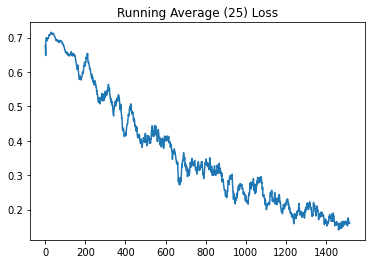




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 2	TRIAL 2	TRIAL 2	TRIAL 2	TRIAL 2	TRIAL 2	TRIAL 2	TRIAL 2
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 1812
	Loading model...


Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


	Loading tokenizer...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


			Batch   50 Loss:	0.726508
			Batch  100 Loss:	0.674937
			Batch  150 Loss:	0.645586
			Batch  200 Loss:	0.608364
		Training Results:
		Loss: 0.658045
		Validation Results:
		Loss: 0.610727	F1: 0.7153
			Recall: 0.8177	Precision: 0.6356
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.596001	F1: 0.7328
			Recall: 0.8458	Precision: 0.6464
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.540833
			Batch  100 Loss:	0.534576
			Batch  150 Loss:	0.531664
			Batch  200 Loss:	0.474367
		Training Results:
		Loss: 0.515725
		Validation Results:
		Loss: 0.521997	F1: 0.7685
			Recall: 0.8646	Precision: 0.6917
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.457996	F1: 0.8161
			Recall: 0.9019	Precision: 0.7452
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 3	 ==============

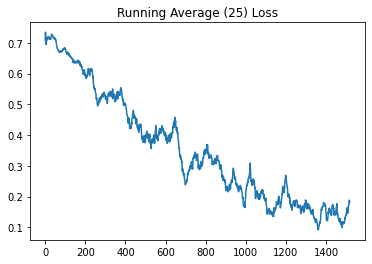




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 3	TRIAL 3	TRIAL 3	TRIAL 3	TRIAL 3	TRIAL 3	TRIAL 3	TRIAL 3
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 4133
	Loading model...


Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


	Loading tokenizer...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.705108
			Batch  100 Loss:	0.653265
			Batch  150 Loss:	0.636110
			Batch  200 Loss:	0.600100
		Training Results:
		Loss: 0.644263
		Validation Results:
		Loss: 0.571521	F1: 0.7025
			Recall: 0.6458	Precision: 0.7702
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.572348	F1: 0.7126
			Recall: 0.7009	Precision: 0.7246
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.510580
			Batch  100 Loss:	0.498195
			Batch  150 Loss:	0.522725
			Batch  200 Loss:	0.475656
		Training Results:
		Loss: 0.500093
		Validation Results:
		Loss: 0.445717	F1: 0.7959
			Recall: 0.8021	Precision: 0.7897
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.501916	F1: 0.7634
			Recall: 0.7991	Precision: 0.730

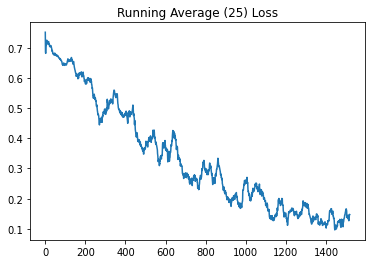




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 4	TRIAL 4	TRIAL 4	TRIAL 4	TRIAL 4	TRIAL 4	TRIAL 4	TRIAL 4
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 1318
	Loading model...


Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


	Loading tokenizer...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.724808
			Batch  100 Loss:	0.674906
			Batch  150 Loss:	0.623963
			Batch  200 Loss:	0.628067
		Training Results:
		Loss: 0.652774
		Validation Results:
		Loss: 0.581717	F1: 0.7247
			Recall: 0.8021	Precision: 0.6609
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.567007	F1: 0.7293
			Recall: 0.7617	Precision: 0.6996
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.577607
			Batch  100 Loss:	0.520539
			Batch  150 Loss:	0.513596
			Batch  200 Loss:	0.494167
		Training Results:
		Loss: 0.518999
		Validation Results:
		Loss: 0.494414	F1: 0.8009
			Recall: 0.9323	Precision: 0.7020
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.496891	F1: 0.7851
			Recall: 0.8879	Precision: 0.703

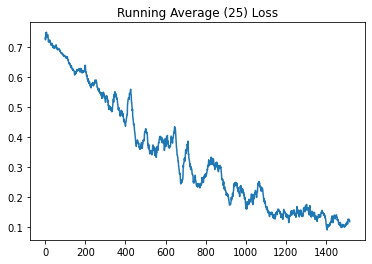




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 5	TRIAL 5	TRIAL 5	TRIAL 5	TRIAL 5	TRIAL 5	TRIAL 5	TRIAL 5
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 38
	Loading model...


Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


	Loading tokenizer...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.723170
			Batch  100 Loss:	0.675987
			Batch  150 Loss:	0.620670
			Batch  200 Loss:	0.606004
		Training Results:
		Loss: 0.653106
		Validation Results:
		Loss: 0.561459	F1: 0.7402
			Recall: 0.8385	Precision: 0.6626
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.551958	F1: 0.7695
			Recall: 0.8738	Precision: 0.6875
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.565400
			Batch  100 Loss:	0.517592
			Batch  150 Loss:	0.503124
			Batch  200 Loss:	0.478392
		Training Results:
		Loss: 0.511083
		Validation Results:
		Loss: 0.501382	F1: 0.7849
			Recall: 0.9219	Precision: 0.6834
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.488675	F1: 0.8162
			Recall: 0.9439	Precision: 0.718

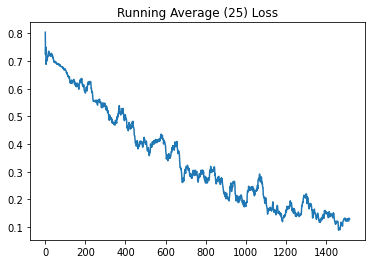




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 6	TRIAL 6	TRIAL 6	TRIAL 6	TRIAL 6	TRIAL 6	TRIAL 6	TRIAL 6
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 8836
	Loading model...


Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


	Loading tokenizer...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.702973
			Batch  100 Loss:	0.674844
			Batch  150 Loss:	0.649623
			Batch  200 Loss:	0.604859
		Training Results:
		Loss: 0.650858
		Validation Results:
		Loss: 0.612040	F1: 0.6783
			Recall: 0.7083	Precision: 0.6507
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.595819	F1: 0.6993
			Recall: 0.7336	Precision: 0.6681
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.589319
			Batch  100 Loss:	0.556477
			Batch  150 Loss:	0.529611
			Batch  200 Loss:	0.503593
		Training Results:
		Loss: 0.538042
		Validation Results:
		Loss: 0.526221	F1: 0.7423
			Recall: 0.7500	Precision: 0.7347
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.486647	F1: 0.7703
			Recall: 0.7523	Precision: 0.789

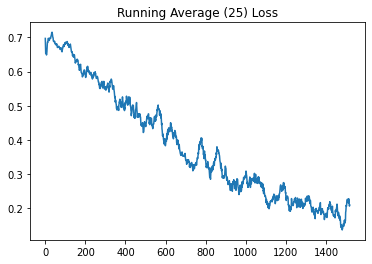




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 7	TRIAL 7	TRIAL 7	TRIAL 7	TRIAL 7	TRIAL 7	TRIAL 7	TRIAL 7
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 431
	Loading model...


Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


	Loading tokenizer...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.710574
			Batch  100 Loss:	0.659670
			Batch  150 Loss:	0.637620
			Batch  200 Loss:	0.609051
		Training Results:
		Loss: 0.644011
		Validation Results:
		Loss: 0.564488	F1: 0.7444
			Recall: 0.7812	Precision: 0.7109
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.553692	F1: 0.7539
			Recall: 0.7944	Precision: 0.7173
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.560015
			Batch  100 Loss:	0.549938
			Batch  150 Loss:	0.521954
			Batch  200 Loss:	0.518331
		Training Results:
		Loss: 0.534598
		Validation Results:
		Loss: 0.548848	F1: 0.7720
			Recall: 0.8906	Precision: 0.6813
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.548258	F1: 0.7695
			Recall: 0.8972	Precision: 0.673

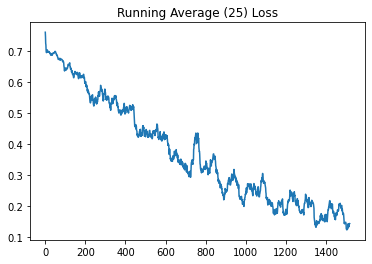




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 8	TRIAL 8	TRIAL 8	TRIAL 8	TRIAL 8	TRIAL 8	TRIAL 8	TRIAL 8
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 9904
	Loading model...


Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


	Loading tokenizer...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.714092
			Batch  100 Loss:	0.663724
			Batch  150 Loss:	0.622731
			Batch  200 Loss:	0.606383
		Training Results:
		Loss: 0.644924
		Validation Results:
		Loss: 0.569241	F1: 0.7240
			Recall: 0.7240	Precision: 0.7240
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.555998	F1: 0.7332
			Recall: 0.7383	Precision: 0.7281
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.596374
			Batch  100 Loss:	0.540717
			Batch  150 Loss:	0.528442
			Batch  200 Loss:	0.524446
		Training Results:
		Loss: 0.541624
		Validation Results:
		Loss: 0.515183	F1: 0.7644
			Recall: 0.8281	Precision: 0.7098
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.488348	F1: 0.7828
			Recall: 0.8925	Precision: 0.697

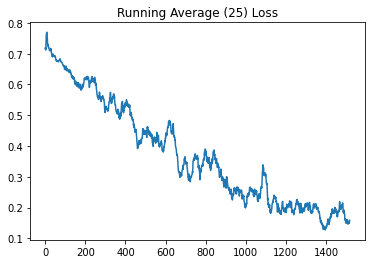




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 9	TRIAL 9	TRIAL 9	TRIAL 9	TRIAL 9	TRIAL 9	TRIAL 9	TRIAL 9
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 6643
	Loading model...


Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


	Loading tokenizer...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.725408
			Batch  100 Loss:	0.676800
			Batch  150 Loss:	0.647396
			Batch  200 Loss:	0.613716
		Training Results:
		Loss: 0.655182
		Validation Results:
		Loss: 0.569940	F1: 0.7444
			Recall: 0.8646	Precision: 0.6535
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.607877	F1: 0.7154
			Recall: 0.8692	Precision: 0.6078
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.577641
			Batch  100 Loss:	0.484054
			Batch  150 Loss:	0.502544
			Batch  200 Loss:	0.458447
		Training Results:
		Loss: 0.502181
		Validation Results:
		Loss: 0.506911	F1: 0.7662
			Recall: 0.7083	Precision: 0.8344
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.509895	F1: 0.7259
			Recall: 0.6869	Precision: 0.769

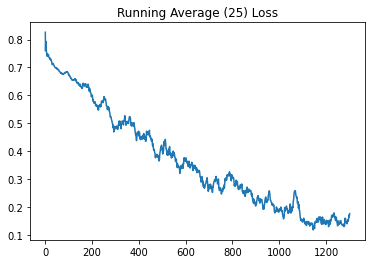




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 10	TRIAL 10	TRIAL 10	TRIAL 10	TRIAL 10	TRIAL 10	TRIAL 10	TRIAL 10
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 4253
	Loading model...


Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


	Loading tokenizer...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.729196
			Batch  100 Loss:	0.667151
			Batch  150 Loss:	0.642504
			Batch  200 Loss:	0.608617
		Training Results:
		Loss: 0.655877
		Validation Results:
		Loss: 0.562727	F1: 0.7093
			Recall: 0.6927	Precision: 0.7268
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.545886	F1: 0.7303
			Recall: 0.7150	Precision: 0.7463
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.567178
			Batch  100 Loss:	0.575337
			Batch  150 Loss:	0.534599
			Batch  200 Loss:	0.490092
		Training Results:
		Loss: 0.540249
		Validation Results:
		Loss: 0.483943	F1: 0.7901
			Recall: 0.9115	Precision: 0.6972
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.511928	F1: 0.7773
			Recall: 0.8972	Precision: 0.685

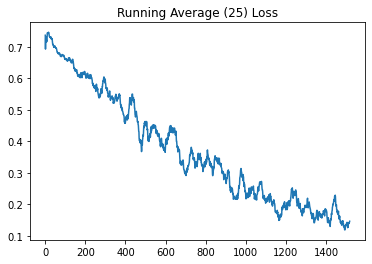




Experiment completed!!


In [ ]:
import matplotlib.pyplot as plt 
NUM_TRIALS = 10
SEEDS = np.random.randint(0, 10000, size=(NUM_TRIALS))
print(SEEDS)

# Fixed hyperparameters
EPOCHS = 7
LR = 1e-5
SAVE = '/content/gdrive/My Drive/'
BSZ = 16 # small due to memory restrictions

pubmedbert = Experiment(num_trials=NUM_TRIALS,
                      data=X,
                      labels=y,
                      model_type='pubmedbert',
                      frozen=False,
                      epochs=EPOCHS,
                      bsz=BSZ,
                      lr=LR,
                      path='pubmedbert',
                      seeds=SEEDS
                      )


pubmedbert.run_experiments()


# Testing

In [ ]:
def standardize_text(string):
  """
  Removes non-alphanumeric characters except hyphens
  Removes extra whitespaces
  """
  pattern = re.compile('[\W_]+')
  temp = pattern.sub(' ', string)
  temp = ' '.join(temp.split())
  temp = temp.lower()

  return temp


def make_tuple(string):
  toks = string.split('&')
  for i, tok in enumerate(toks):
    t = tok.split()
    t = ' '.join(t)
    toks[i] = t
  return tuple(toks)

def joining(text, triple):
  if len(triple) != 3:
    print(triple)
    a,b,c,d = triple
    if 'Rehabilitation' in d or 'Oral' in c:
      obj = ' '.join((c,d))
      sub = a
      pred = b
    elif 'F-525-A' in d:
      obj = 'SKF-525-A'
      sub = a
      pred = b  
    elif 'P' in c:
      obj = 'e.p.p.s'
      sub = a
      pred = b  
    elif 'F-38393' in d:
      obj = 'SKF-38393'  
      sub = a
      pred = b  
    else:
      obj = ' '.join((c,d))
      sub = a
      pred = b
    if 'analogs' in a or 'antagonists' in a:
      sub =' '.join((a,b))
      pred = c
      obj = d
    text = ' '.join(text.split()) # Clears extra spac
    text += f" [SEP] {sub} {pred} {obj}"
    print(text)
  else:
    sub, pred, obj = triple
    text = ' '.join(text.split()) # Clears extra spaces
    text += f" [SEP] {sub} {pred} {obj}"

  return text
def triple_joining(triple):
  sub, pred, obj = triple
  return ' '.join([sub, pred, obj])


class SemMedDataset_test(Dataset):
  """
  Dataset class for the several input components
  """
  def __init__(self, input_ids, token_type_ids, attention_masks):
    self.input_ids = input_ids
    self.token_types = token_type_ids
    self.attn_masks = attention_masks

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    return self.input_ids[idx], self.token_types[idx], self.attn_masks[idx]


In [ ]:
SAVE = ''

bert = PubMedBERT()  # Best performing model
#bert.load_state_dict(torch.load(SAVE+'pubmed_bert_best.pth',map_location=torch.device('cpu')))
bert.load_state_dict(torch.load(SAVE+'pubmed_bert_best.pth'))
bert.eval()
tokenizer = AutoTokenizer.from_pretrained(bert.weight_path)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
bert.to(device)
import csv
f = open(SAVE+'1.tsv')
data = []
for line in f:
    data_line = line.rstrip().split('\t')
    data.append(data_line)
data = pd.DataFrame(data)
data.columns = ['SUBJECT_CUI', 'SUBJECT_NAME', 'SUBJECT_SEM_TYPE', 'PREDICATE', 'OBJECT_CUI', 'OBJECT_NAME', 'OBJECT_SEM_TYPE', 'YEAR', 'EDAT', 'PUBMED_ID', 'sent_id', 'SENTENCE']
data = data[['SUBJECT_NAME','PREDICATE','OBJECT_NAME','EDAT','SENTENCE']]
data['SENTENCE'] = data.SENTENCE.astype('string')
data['SUBJECT_NAME'] = data.SUBJECT_NAME.astype('string')
data['OBJECT_NAME'] = data.OBJECT_NAME.astype('string')
data['PREDICATE'] = data.PREDICATE.astype('string')
data['TRIPLE'] = (data.SUBJECT_NAME + '&' + data.PREDICATE + '&' +data.OBJECT_NAME).apply(make_tuple)

data_x = data[['SENTENCE','TRIPLE']]
data_x = np.vectorize(joining)(data_x.SENTENCE, data_x.TRIPLE)
data_x = [str(i) for i in data_x]
encoding = tokenizer(data_x, return_tensors='pt',padding=True, truncation=True, verbose=False)
import torch, gc
gc.collect()
torch.cuda.empty_cache()
keep = []

input_ids = encoding['input_ids']
token_type_ids = encoding['token_type_ids']
attn_mask = encoding['attention_mask']
test_data = SemMedDataset_test(input_ids,token_type_ids,attn_mask)
test_data = DataLoader(test_data)
for i, (input_id, ttid, attn_mask) in enumerate(test_data):
  input_id, ttid = input_id.to(device)[:,:512], ttid.to(device)[:,:512]
  attn_mask = attn_mask.to(device)[:,:512]
  try:
    output = bert(input_id, ttid, attn_mask)
  except:
    print(input_id,ttid,attn_mask,len(input_id[0]),len(ttid[0]),len(attn_mask[0]))
    print(i)
    continue
  #print(output)
  clf = torch.max(F.softmax(output[0], 1), 1)[0].cpu().detach().item()
  if clf > 0.5:
    #print(clf)
    keep.append(data.loc[i])
  
keep = pd.DataFrame(keep)
keep.to_csv(SAVE+'filtered_preds_1.csv', sep='|', header=True, index=False)

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/221k [00:00<?, ?B/s]

cpu
('ambulatory care services', 'TREATS', 'Physical Medicine', 'Rehabilitation')
POPULATION: Patients referring to Italian PRM outpatient rehabilitation services and Italian Residents in PRM. [SEP] ambulatory care services TREATS Physical Medicine Rehabilitation
('analogs', 'derivatives', 'INTERACTS_WITH', 'Nucleosides')
Although none of the compounds showed pronounced cytostatic activity and were devoid of a significant antiviral potential, the double-headed nucleoside derivatives 8a, 8c and 8e showed a moderate cytostatic activity against human cervix carcinoma HeLa cells which may be the basis for the synthesis of analogous derivatives with improved cytostatic potential. [SEP] analogs derivatives INTERACTS_WITH Nucleosides
('analogs', 'derivatives', 'INTERACTS_WITH', 'metaperiodate')
The affinity reagents received by periodate oxidation of bifunctional ATP analogs derivatives of di-, tetra- and heptamethylenediamine modify non-identical subunits of creatine kinase with different ve